$\large{\text{Minimize, regression approach}}$

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import functools
import h5py
import pandas as pd
import openpyxl

$\large{\text{Define Functions}}$ $\\$
In this code we define the function used for the minimize regression for fitting a matrix model to eigenvalue data

In [2]:
def cost_func(reg_param, sweep_param, data, **kwargs): #Not implemented kwargs
    ev = eigenvalues(sweep_param, *reg_param, **kwargs)
    data = data
    mse = np.mean((ev - data)**2, axis=1)
    #print(sum(mse), reg_param) #For testing purposes
    return sum(mse)

def eigenvalues(sweep_param, *reg_param, **kwargs):
    #Unpack kwargs
    hamiltonian = kwargs['hamiltonian']
    if len(sweep_param) > 1:
        eig_values = np.zeros((len(sweep_param), len(hamiltonian(sweep_param[0], reg_param))))
        for i in range(len(sweep_param)):
            matrix = hamiltonian(sweep_param[i], reg_param)
            eig_val, eig_vec = scipy.linalg.eigh(matrix)
            eig_val = np.flip(eig_val) 
            eig_values[i,:] = eig_val - np.min(eig_val)
    #For one specific delta value
    elif len(sweep_param) == 1:
        matrix = hamiltonian(sweep_param, reg_param)
        eig_val, eig_vec = scipy.linalg.eigh(matrix)
        eig_values = np.flip(eig_val) - min(eig_val)
    return eig_values

def gen_data(sweep_param, *reg_param, **kwargs): #stadev, hamiltonian
    #Unpack kwargs
    stadev = kwargs['stadev']
    hamiltonian = kwargs['hamiltonian']
    #Pack new kwargs
    kwargs = {"hamiltonian": hamiltonian}
    data = eigenvalues(sweep_param, *reg_param, **kwargs)
    noise = np.random.normal(loc=0, scale=stadev, size=((len(sweep_param), len(hamiltonian(sweep_param[0], reg_param)))))
    return data+noise

def find_optimal_param(hamiltonian, data, sweep_param, inital_guess, file_name, max_iter):
    ## Pack your model as kwargs for the minimize function
    kwargs = {"hamiltonian": hamiltonian}
    ## Use SciPy library for the minimization
    res = scipy.optimize.minimize(functools.partial(cost_func, **kwargs), x0 = inital_guess, method="Nelder-Mead", tol=1e-100, args=(sweep_param, data), options={'return_all': True, 'adaptive': True,'maxiter':max_iter, 'maxfev':max_iter*1000}) 
    ## Convert your array into a dataframe
    df = pd.DataFrame (res.allvecs)
    ## Save to xlsx file
    df.to_excel(file_name, index=False)
    return res

$\large{\text{Define Matrices}}$ $\\$
This code cell defines the two-, three- and nine-level system matrix model

In [3]:
def matrix2d(sweep_param, reg_param):
    delta = sweep_param
    #Unpack args
    g = reg_param[0]
    matrix = np.zeros((2, 2))
    matrix[0,0] = -delta
    matrix[1,1] = delta
    matrix[0,1] = g
    matrix[1,0] = g
    return matrix

def matrix3d(sweep_param, *reg_param):
    wc = sweep_param
    #Unpack args
    w1, w2, g1c, g2c, g12 = reg_param[0]
    matrix = np.zeros((3,3))
    matrix[0,0] = w1
    matrix[1,1] = w2
    matrix[2,2] = wc
    matrix[0,1] = g12
    matrix[1,0] = g12
    matrix[0,2] = g1c
    matrix[2,0] = g1c
    matrix[1,2] = g2c
    matrix[2,1] = g2c
    return matrix

def matrix9d(sweep_param, *reg_param):
    wc = sweep_param
    #Unpack args
    w1, w2, g1c, g2c, g12, a1, a2, ac = reg_param[0]
    matrix = np.zeros((9,9))
    matrix[0,0] = w1
    matrix[1,1] = w2
    matrix[2,2] = wc
    matrix[0,1] = g12
    matrix[1,0] = g12
    matrix[0,2] = g1c
    matrix[2,0] = g1c
    matrix[1,2] = g2c
    matrix[2,1] = g2c
    
    matrix[3,3] = w1 + w2
    matrix[4,4] = w1 + wc
    matrix[5,5] = w2 + wc
    matrix[3,4] = g2c
    matrix[4,3] = g2c
    matrix[3,5] = g1c
    matrix[5,3] = g1c
    matrix[4,5] = g12
    matrix[5,4] = g12
    
    matrix[6,6] = 2*w1+a1
    matrix[7,7] = 2*w2+a2
    matrix[8,8] = 2*wc+ac
    
    matrix[6,3] = np.sqrt(2)*g12
    matrix[3,6] = np.sqrt(2)*g12
    matrix[7,3] = np.sqrt(2)*g12
    matrix[3,7] = np.sqrt(2)*g12
    matrix[6,4] = np.sqrt(2)*g1c
    matrix[4,6] = np.sqrt(2)*g1c
    matrix[8,4] = np.sqrt(2)*g1c
    matrix[4,8] = np.sqrt(2)*g1c
    matrix[7,5] = np.sqrt(2)*g2c
    matrix[5,7] = np.sqrt(2)*g2c
    matrix[8,5] = np.sqrt(2)*g2c
    matrix[5,8] = np.sqrt(2)*g2c
    return matrix

$\large{\text{Import complex data}}$ $\\$
In this part we import the complex data given to us by our instructors for whom is intrested in doing som experiments on the same data

In [4]:
## Extract data from a more complex model
def sorting(eigenvalues,zerolevel=0):
    eigenvalues = np.sort(eigenvalues,axis=-1)/(2*np.pi)
    for a in range(len(eigenvalues)):
        eigenvalues[a,:]=eigenvalues[a,:]-eigenvalues[a,zerolevel]
    return eigenvalues


Data = h5py.File('Simulerad_Data.hdf5', "r")
Data = pd.DataFrame(Data["eigenv"])
Data = Data.to_numpy()

## Data is given with lowest eigenvalue first, functions right now uses biggest first, just flip along the -1 axis
eigenvalues10 = np.flip(sorting(Data), -1)
eigenvalues9 = np.flip(sorting(Data,1)[:,1:], -1)
eigenvalues3 = np.flip(sorting(Data,1)[:,1:4], -1)
eigenvalues6 = np.flip(sorting(Data,4)[:,4:], -1)

## Define sweep parameters used to genrate the complex data
wc = np.linspace(2.5,7.5, 1001)

$\large{\text{Generate Data}}$

$\textbf{Parameters to define}$ $\\$
Define what model to generate data from, the function that generates the data must take as first argument "reg_params" and as second argument "*sweep_param". The model function must return a square numpy.array $\\$
Define what "sweep_param"-array and "reg_param"-array to generate data acordning to, the sweep parameter is a known parameter used in the acquisition of data, and regression parameters are physically related parameters for the model $\\$
Define what noise level to apply to the data, in relation to the regression parameters. If none stadev = 0

$\textbf{Function to call}$ $\\$
Call the "gen_data"-function as data = gen_data(sweep_param, *reg_param, **kwargs), where kwargs contains an dict as {"stadev": noise_level, "hamiltonian": 'model_function_to_genrated_from'}

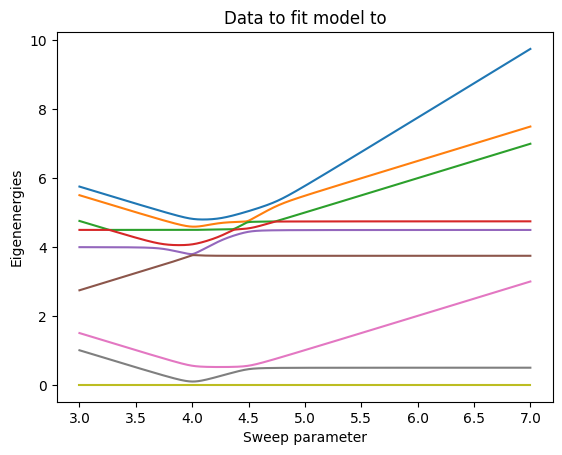

In [19]:
## Define parameters for data generation
sweep_param = np.linspace(3, 7, 1000)
parameter_names = np.array(["w1", "w2", "g1c", "g2c", "g12", "a1", "a2", "a3"])
reg_param = np.array([4, 4.5, 0.05, 0.05, 0.005, -0.25, -0.25, -0.25])
stadev = 0

kwargs = {"stadev": stadev, "hamiltonian": matrix9d}
data = gen_data(sweep_param, *reg_param, **kwargs)

## Show the generated data

plt.plot(sweep_param, data)
plt.title("Data to fit model to")
plt.xlabel("Sweep parameter")
plt.ylabel("Eigenenergies")
plt.show()

$\large{\text{Minimize Mean Squared Error Sum}}$

$\textbf{Step 1:}$ Define what matrix model to fit, hamiltonian = 'matrix_function_name' $\\$
The model function must take an sequnece of parameters as the first argument "reg_params". $\\$
The model function also must take an array of the sweeping parameter as the second argument "*sweep_param". $\\$
The model function must returns the model matrice as an numpy.array

$\textbf{Step 2:}$ Define what initial guess to use, inital_guess = np.array(['Parameter_initial_guess_in_order']) $\\$
The inital guess is orderd in the same order as the "reg_params" defined in the model to fit

$\textbf{Step 3:}$ Define what data to use: data = 'name_of_data_array' which is an MxN array $\\$
Each row is a new measurment point with a corresponding value for the sweeping parameter, total number of data points is M $\\$
Must have the same number of columns as the size of the model, which is NxN, each column represent a measured eigenenergy at that specific sweeping parameter value $\\$
The eigenenergies must be orderd from biggest to smallest 

$\textbf{Step 4:}$ Define the "sweeping_param"-array with all used sweeping parameter values for the data array  $\\$
This should have length M

$\textbf{Step 5:}$ Define maximum number of iterations max_iter = 'Maximum number of wanted minimze iterations'  $\\$
This specifies when the regression should conclude

$\textbf{Step 6:}$ Define name of the file the results are saved to file_name = 'Name of file' $\\$

$\textbf{Step 7:}$ Insert all defined varibles to the "find_optimal_param"-function as optimal_param = find_optimal_param(hamiltonian, ) $\\$ 
The function will return the full result from the minimization and save the parameters values for each iteration in an xlsx file



In [20]:
## Define varibles to use for the minimization
hamiltonian = matrix9d
inital_guess = np.array([5,5,0.04,0.04,0.004,-0.2,-0.2,-0.2])
data = data_9d
sweep_param = sweep_param_9d
max_iter = 1600
file_name = "Test_1.xlsx"

## Run the minimization to find the optimal parameters
optimal_param = find_optimal_param(hamiltonian, data, sweep_param, inital_guess, file_name, max_iter)

## print out the results, they are also saved in specified file
print(optimal_param)

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 1.0169926329688684e-06
             x: [ 4.000e+00  4.500e+00  4.992e-02  5.004e-02  4.545e-03
                 -2.500e-01 -2.499e-01 -2.500e-01]
           nit: 1600
          nfev: 2604
 final_simplex: (array([[ 4.000e+00,  4.500e+00, ..., -2.499e-01,
                        -2.500e-01],
                       [ 4.000e+00,  4.500e+00, ..., -2.499e-01,
                        -2.500e-01],
                       ...,
                       [ 4.000e+00,  4.500e+00, ..., -2.499e-01,
                        -2.500e-01],
                       [ 4.000e+00,  4.500e+00, ..., -2.499e-01,
                        -2.500e-01]]), array([ 1.017e-06,  1.076e-06,  1.170e-06,  1.174e-06,
                        1.229e-06,  1.302e-06,  1.355e-06,  1.464e-06,
                        1.507e-06]))
       allvecs: [array([ 5.000e+00,  5.000e+00,  4.000e-02,  4.000e-02,
                  